# Spectrograms

This tutorial demonstrates how to use OpenSoundscape to create spectrograms from audio files, inspect spectrogram properties, and modify spectrograms.

## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/spectrogram.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/spectrogram.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [1]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install git+https://github.com/kitzeslab/opensoundscape@develop ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0

## Quick start

The "quick start" code below demonstrates a basic pipeline for downloading an audio file, loading it into OpenSoundscape, and creating a spectrogram from it

### Import needed classes

Import the `Audio` and `Spectrogram` classes from OpenSoundscape. 

(For more information about Python imports, review [this](https://medium.com/code-85/a-beginners-guide-to-importing-in-python-bb3adbbacc2b) article.)

In [2]:
# Import Audio and Spectrogram classes from OpenSoundscape
from opensoundscape import Audio, Spectrogram

#other utilities
from pathlib import Path

### Get an example audio file

Here we download an example birdsong soundscape recorded by an AudioMoth autonomous recorder in Pennsylvania, USA.

In [3]:
audio_object=Audio.from_url('https://tinyurl.com/birds60s')
# or load a local file:
# a = Audio.from_file('/local/file/path')
audio_object

<Audio(samples=(1920000,), sample_rate=32000)>

## Create and plot spectrograms


Spectrograms are images where the horizontal axis represents time and the vertical axis represents frequencies. 

### Create spectrogram

Spectrograms can be created from `Audio` objects using the `Spectrogram` class. 

For more information about loading and modifying audio files, see the Audio tutorial.


In [4]:
spectrogram_object = Spectrogram.from_audio(audio_object)

### Plot spectrogram

A `Spectrogram` object can be visualized using its `plot()` method.

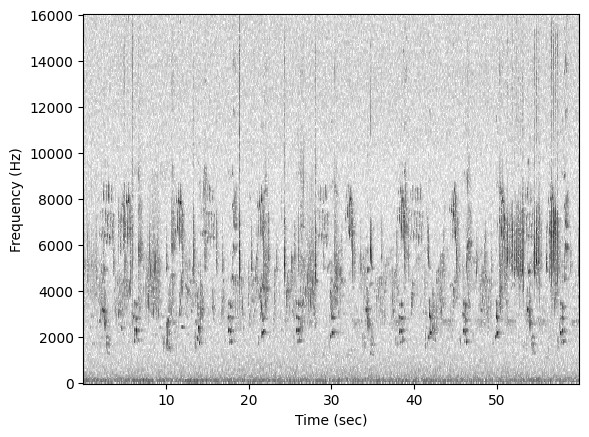

In [5]:
spectrogram_object.plot()

## Customize spectrograms

While the code above shows how to create a spectrogram with default parameters, most applications require carefully selecting spectrogram parameters that best fit your application. 

Spectrograms can be customized both as you create a spectrogram and after you create a spectrogram. When you **create** a spectrogram, you can customize the following parameters:

In [6]:
# View the documentation about this method
Spectrogram.from_audio?

Signature:
Spectrogram.from_audio(
    audio,
    window_type='hann',
    window_samples=None,
    window_length_sec=None,
    overlap_samples=None,
    overlap_fraction=None,
    fft_size=None,
    dB_scale=True,
    scaling='spectrum',
    **kwargs,
)
Docstring:
create a Spectrogram object from an Audio object

Args:
    audio: Audio object
    window_type="hann": see scipy.signal.spectrogram docs
    window_samples: number of audio samples per spectrogram window (pixel)
        - Defaults to 512 if window_samples and window_length_sec are None
        - Note: cannot specify both window_samples and window_length_sec
    window_length_sec: length of a single window in seconds
        - Note: cannot specify both window_samples and window_length_sec
        - Warning: specifying this parameter often results in less efficient
            spectrogram computation because window_samples will not be
            a power of 2.
    overlap_samples: number of samples shared by consecutive window

### Window parameters, explained

Spectrograms are created using **windows**. A window is a subset of consecutive samples of the original audio that is analyzed to create one pixel in the horizontal direction (one "column") on the resulting spectrogram. 

The appearance of a spectrogram depends on two parameters that control the size and spacing of these windows, the samples per window and the overlap of consecutive windows.

#### Samples per window, `window_samples`
This parameter is the length (in audio samples) of each spectrogram window. 

Choosing the value for `window_samples` represents a trade-off between frequency resolution and time resolution:
* Larger value for `window_samples` --> higher frequency resolution (more rows in a single spectrogram column)
* Smaller value for `window_samples` --> higher time resolution (more columns in the spectrogram per second)

As an alternative to specifying window size using `window_samples`, you can instead specify size using `window_length_sec`, the window length in seconds (equivalent to `window_samples` divided by the audio's sample rate).

#### Overlap of consecutive windows, `overlap_samples`
`overlap_samples`: this is the number of audio samples that will be re-used (overlap) between two consecutive Specrogram windows.

It must be less than `window_samples` and greater than or equal to zero. Zero means no overlap between windows, while a value of `window_samples`/2 would give 50% overlap between consecutive windows. 

Using higher overlap percentages can sometimes yield better time resolution in a spectrogram, but will take more computational time to generate. 

As an alternative to specifying window overlap using `overlap_samples`, you can instead specify overlap using `overlap_fraction`.

#### Spectrogram parameter tradeoffs

When there is zero overlap between windows, the number of columns per second is equal to the size in Hz of each spectrogram row. Consider the relationship between time resolution (columns in the spectrogram per second) and frequency resolution (rows in a given frequency range) in the following example:

* Let `sample_rate=48000`, `window_samples=480`, and `overlap_samples=0`

* Each window ("spectrogram column") represents `480/48000 = 1/100 = 0.01` seconds of audio

* There will be `1/(length of window in seconds) = 1/0.01` = 100 columns in the spectrogram per second.

* Each pixel will span 100 Hz in the frequency dimension, i.e., the lowest pixel spans 0-100 Hz, the next lowest 100-200 Hz, then 200-300 Hz, etc.

If `window_samples=4800`, then the spectrogram would have better time resolution (each window represents only 4800/48000 = 0.001s of audio) but worse frequency resolution (each row of the spectrogram would represent 1000 Hz in the frequency range).

### Time and frequency resolution

By modifying the window parameters explained above, we can adjust the time and frequency resolution of spectrograms.

As an example, let's create two spectrograms, one with high time resolution and another with high frequency resolution.

#### Spectrogram with high time resolution

Using `window_samples=55` and `overlap_samples=0` gives 55/22000 = 0.0025 seconds of audio per window, or 1/0.0025 = 400 windows per second. Each spectrogram pixel spans 400 Hz.

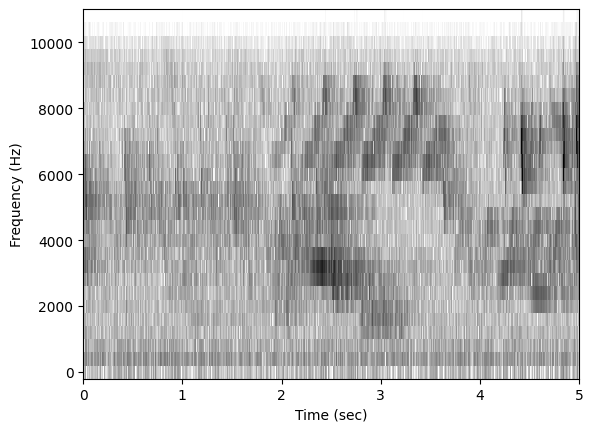

In [7]:
# Load audio
audio = audio_object.resample(22000).trim(0,5)

spec = Spectrogram.from_audio(
    audio, 
    window_samples=55,
    overlap_samples=0)
spec.plot()

#### Spectrogram with high frequency resolution

Using `window_samples=1100` and `overlap_samples=0` gives 1100/22000 = 0.05 seconds of audio per window, or 1/0.05 = 20 windows per second. Each spectrogram pixel spans 20 Hz.

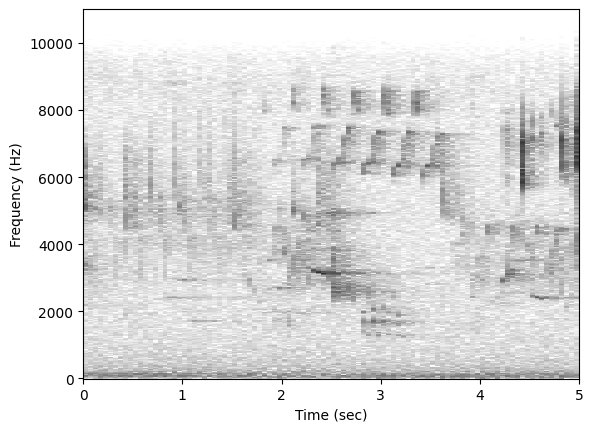

In [8]:
spec = Spectrogram.from_audio(
    audio,
    window_samples=1100,
    overlap_samples=0)
spec.plot()

### Window type and FFT size

The other window parameters OpenSoundscape allows you to modify are:

* `window_type`: see scipy.signal.spectrogram docs
* `fft_size`: see scipy.signal.spectrogram's `nfft` parameter

### Decibel parameters

Spectrogram.plot also allows you to limit the decibel values of a spectrogram. This can be useful for removing low-amplitude sounds in the background, giving the impression of removing background noise. The default plotting range is -100 dB to -20 dB.

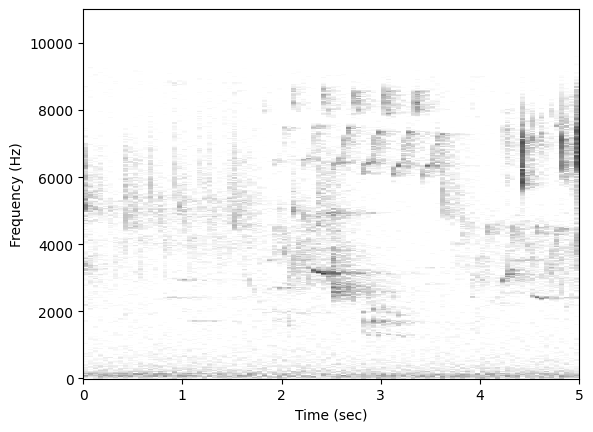

In [9]:
spec.plot(range=(-80,-20))

### Mel spectrograms

In addition to creating linear frequency scale spectrograms, OpenSoundscape also allows users to create "mel" frequency scale spectrograms using the `MelSpectrogram` class.

A mel spectrogram is a spectrogram with pseudo-logarithmically spaced frequency bins (see literature) rather than linearly spaced bins. This frequency scale has often been used in language processing and other domains.

In [10]:
from opensoundscape.spectrogram import MelSpectrogram

In [11]:
melspec = MelSpectrogram.from_audio(audio_object.trim(0,20),window_samples=2048,n_mels=400)

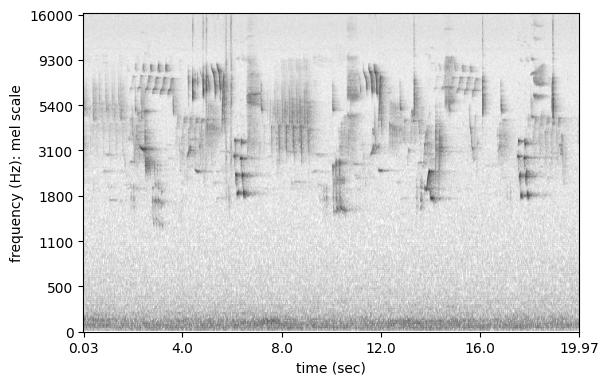

In [12]:
from matplotlib import pyplot as plt
melspec.plot()

### Trim spectrogram

Spectrograms can be trimmed in time using `trim()`. Trim the above spectrogram to zoom in on one vocalization.

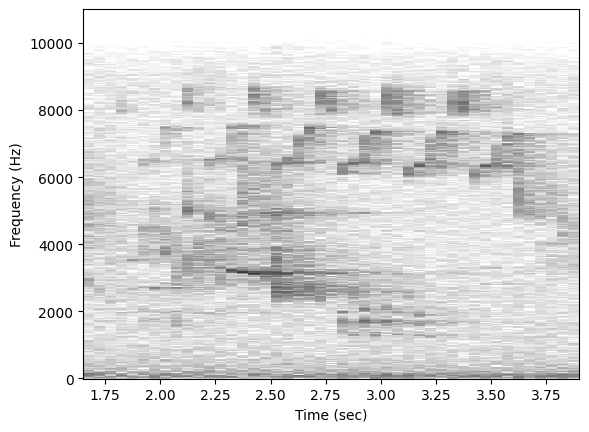

In [13]:
spec_trimmed = spec.trim(1.7, 3.9)
spec_trimmed.plot()

You can accomplish a similar thing by trimming the underlying audio and creating a spectrogram solely from that. Notice that the time-axis is different.

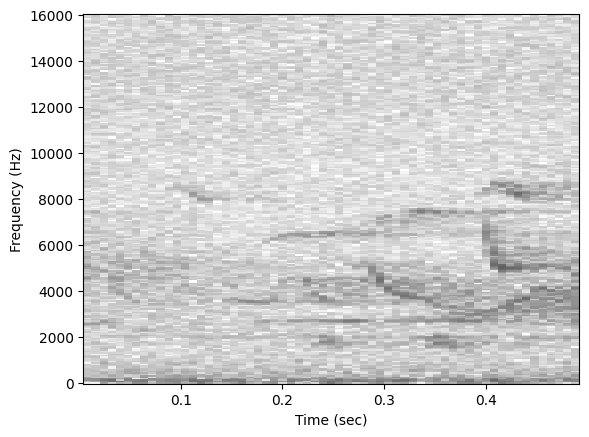

In [14]:
spec = Spectrogram.from_audio(audio_object.trim(1.7,2.2))
spec.plot()

### Bandpass spectrogram

Spectrograms can be trimmed in frequency using `bandpass()`. This simply subsets the Spectrogram array rather than performing an audio-domain filter.

For instance, the vocalization zoomed in on above is the song of a Black-and-white Warbler (*Mniotilta varia*), one of the highest-frequency bird songs in our area. Set its approximate frequency range.

In [15]:
baww_low_freq = 5500
baww_high_freq = 9500

Bandpass the above time-trimmed spectrogram in frequency as well to limit the spectrogram view to the vocalization of interest.

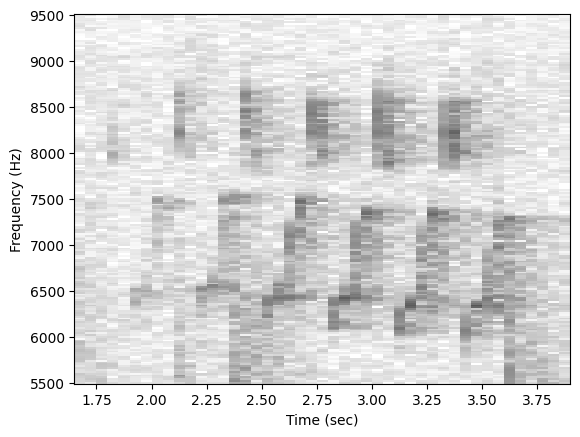

In [16]:
spec_bandpassed = spec_trimmed.bandpass(baww_low_freq, baww_high_freq)
spec_bandpassed.plot()

Unlike trimming in time, you cannot create the same bandpassed spectrogram by modifying the audio, although you can bandpass audio:

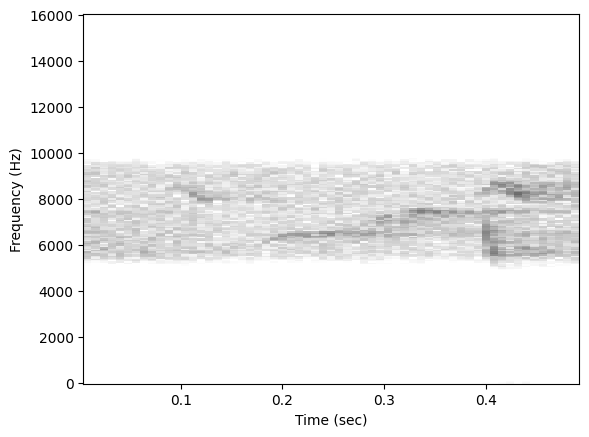

In [17]:
aud = audio_object.trim(1.7,2.2).bandpass(baww_low_freq, baww_high_freq, order=10)
spec = Spectrogram.from_audio(aud)
spec.plot()

## Inspect spectrograms

To learn more about the properties of spectrograms, we can inspect them.

### Spectrogram properties 
To inspect the axes of a spectrogram, you can look at its `times` and `frequencies` attributes. 
* The `times` attribute is the list of the spectrogram windows' centers' times in seconds relative to the beginning of the audio. 
* The `frequencies` attribute is the list of frequencies represented by each row of the spectrogram.

These are not the actual values of the spectrogram — just the values of the steps of each axis.

In [18]:
spec = Spectrogram.from_audio(audio_object)
print(f'The first few times: {spec.times[0:5]}')
print(f'The first few frequencies: {spec.frequencies[0:5]}')

The first few times: [0.008 0.016 0.024 0.032 0.04 ]
The first few frequencies: [  0.   62.5 125.  187.5 250. ]


To view the actual values of the spectrogram, look at its `spectrogram` attribute:

In [19]:
print("Spectrogram shape (# freq bins, # time bins):", spec.spectrogram.shape)
spec.spectrogram

Spectrogram shape (# freq bins, # time bins): (257, 7499)


array([[-58.38818073, -53.94657135, -76.73751354, ..., -59.38414097,
        -55.68588257, -55.95675945],
       [-48.64973068, -51.48958206, -53.39539528, ..., -50.24297237,
        -51.89252377, -52.18490601],
       [-46.81248188, -53.32777977, -51.88463211, ..., -51.72378063,
        -58.68028164, -60.68970203],
       ...,
       [-88.5986042 , -85.61808586, -80.46681404, ..., -79.06273365,
        -73.5153389 , -74.68874454],
       [-78.34392071, -81.92497253, -76.84250355, ..., -78.30162048,
        -70.83772182, -88.2362175 ],
       [-90.27135849, -94.44991112, -80.84282875, ..., -88.39132309,
        -73.99300098, -81.72528267]])

### Sum the columns of a spectrogram

The `.amplitude()` method sums the columns of the spectrogram to create a one-dimensional amplitude versus time vector. 

Note: the amplitude of the Spectrogram (and FFT) has units of power (V**2) over frequency (Hz) on a logarithmic scale

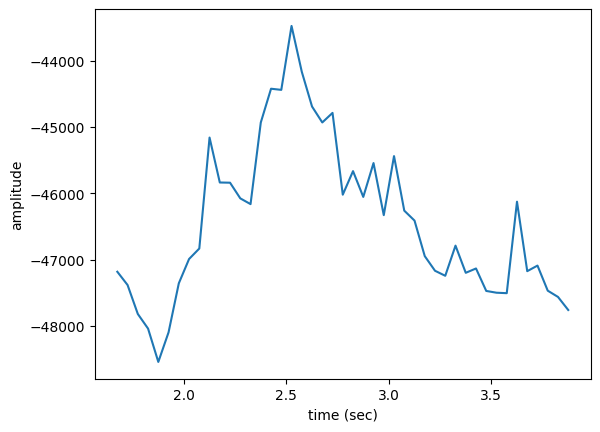

In [20]:
# calculate amplitude signal
high_freq_amplitude = spec_trimmed.amplitude()

# plot
from matplotlib import pyplot as plt
plt.plot(spec_trimmed.times,high_freq_amplitude)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

It is also possible to get the amplitude signal from a restricted range of frequencies, for instance, to look at the amplitude in the frequency range of a species of interest. For example, get the amplitude signal from the 8000 Hz to 8500 Hz range of the audio (displayed below):

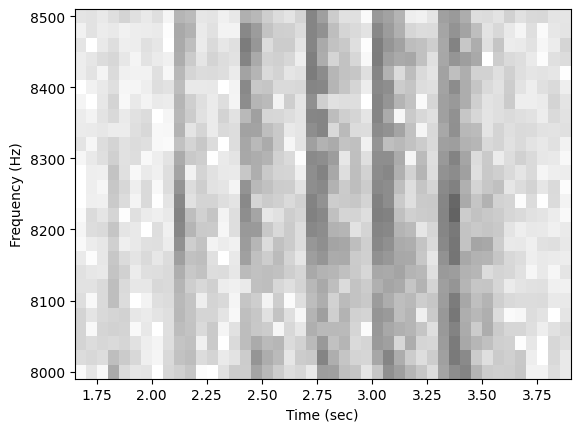

In [21]:
spec_bandpassed = spec_trimmed.bandpass(8000, 8500)
spec_bandpassed.plot()

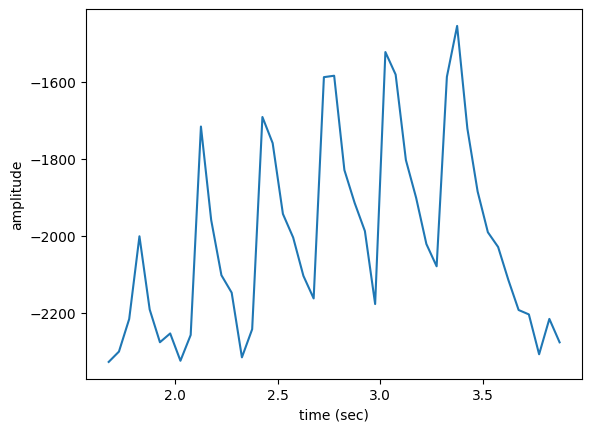

In [22]:
# Get amplitude signal
high_freq_amplitude = spec_trimmed.amplitude(freq_range=[8000,8500])

# Get amplitude signal
high_freq_amplitude = spec_trimmed.amplitude(freq_range=[8000,8500])

# Plot signal
plt.plot(spec_trimmed.times, high_freq_amplitude)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

Amplitude signals like these can be used to identify periodic calls, like those by many species of frogs. A pulsing-call identification pipeline called [RIBBIT](RIBBIT_pulse_rate_demo.html) is implemented in OpenSoundscape.

Amplitude signals may not be the most reliable method of identification for species like birds. In this case, it is possible to create a machine learning algorithm to identify calls based on their appearance on spectrograms. 

The developers of OpenSoundscape have trained machine learning models for over 500 common North American bird species; for examples of how to download demonstration models, see the [Prediction with pre-trained CNNs](predict_with_pretrained_cnn.html) tutorial.

## Save spectrograms

OpenSoundscape can save high-resolution spectrograms directly. It can also be used to create nice spectrogram figures.

### Save basic spectrogram
To save the created spectrogram, first convert it to an image. It will no longer be an OpenSoundscape `Spectrogram` object, but instead a Python Image Library (PIL) `Image` object.

In [23]:
print("Type of `spectrogram_audio` (before conversion):\n", type(spectrogram_object))
spectrogram_image = spectrogram_object.to_image()
print("\nType of `spectrogram_image` (after conversion):\n", type(spectrogram_image))

Type of `spectrogram_audio` (before conversion):
 <class 'opensoundscape.spectrogram.Spectrogram'>

Type of `spectrogram_image` (after conversion):
 <class 'PIL.Image.Image'>


Save the PIL Image using its `save()` method, supplying the filename at which you want to save the image.

In [24]:
image_path = Path('./saved_spectrogram.png')
spectrogram_image.save(image_path)

To save the spectrogram at a desired size, specify the image shape when converting the `Spectrogram` to a PIL `Image`.

In [25]:
image_shape = (512,512)
large_image_path = Path('./saved_spectrogram_large.png')
spectrogram_image = spectrogram_object.to_image(shape=image_shape)
spectrogram_image.save(large_image_path)

### Create spectrogram figure

To create a nice spectrogram figure, e.g. for a presentation or publication, you can modify the spectrogram using `matplotlib.pyplot` functionality.

Here we can pick out the delightful flutelike sound of a Wood Thrush. Give it a listen.

In [26]:
woodthrush_audio = audio_object.trim(9.5, 11.25)
woodthrush_audio.show_widget(normalize=True)

Create a spectrogram:

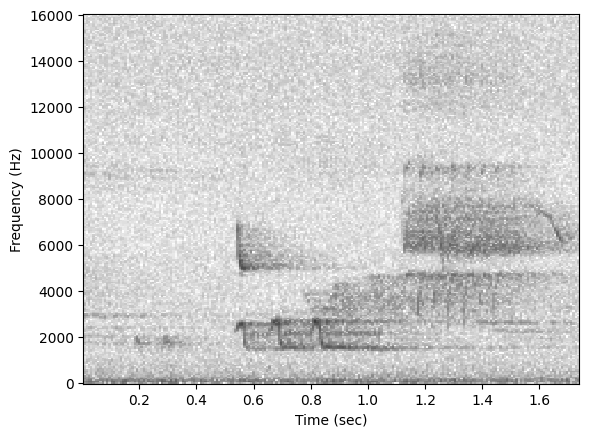

In [27]:
woodthrush_spec = Spectrogram.from_audio(woodthrush_audio)
woodthrush_spec.plot()

The code block below does the following:
* Remove the noise in the lower frequencies in the audio file
* Crop the spectrogram to the most salient features by bandpassing out the upper frequencies
* Gets the spectrogram axes so we can modify the plot appearance itself


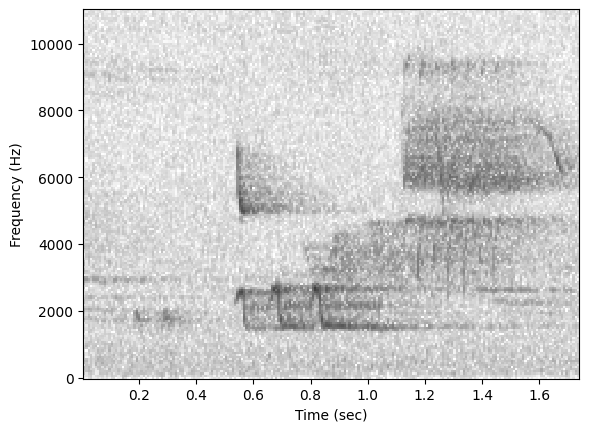

In [28]:
woodthrush_audio = audio_object.trim(9.5, 11.25)

# Bandpass the audio with a low-order bandpass
woodthrush_audio = woodthrush_audio.bandpass(300,12000, order=1)

# Create a spectrogram without the higher frequencies
woodthrush_spec = Spectrogram.from_audio(woodthrush_audio)
woodthrush_spec = woodthrush_spec.bandpass(0, 11025)

# Use matplotlib to get the plot axes
woth_axes = plt.gca()
woodthrush_spec.plot()

Next suppose we want to:
* Change the axis scales and axis labels
* Give the plot a title

In order to modify the plot itself, we have to set the axes to the axes that we just identified. Then we can modify the spectrogram.

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_12100/2304364394.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  woth_axes.set_yticklabels(y_axis_kHz)
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_12100/2304364394.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  woth_axes.set_xticklabels(x_axis_ms)


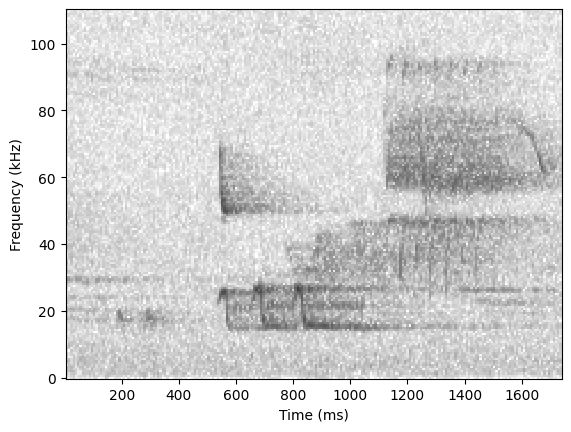

In [29]:
plt.sca(woth_axes)

# Get the x and y tick labels for the plot
y_axis_kHz = woth_axes.get_yticks()/100
x_axis_ms = woth_axes.get_xticks()*1000

# Turn tick labels into strings
y_axis_kHz = [str(f"{int(y)}") for y in y_axis_kHz]
x_axis_ms = [str(f"{int(x)}") for x in x_axis_ms]

# Set the new tick labels
woth_axes.set_yticklabels(y_axis_kHz)
woth_axes.set_xticklabels(x_axis_ms)

# Set the new axis labels
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (kHz)")
plt.show()

And finally save the plot.

In [30]:
# Get the axes back again
plt.sca(woth_axes)

# Save the figure
woth_path = Path("WOTH_plot.png")
plt.savefig(woth_path)

### Basic audio to image pipeline example

The code below demonstrates a basic pipeline:
* Load an audio file
* Generate a spectrogram with default parameters
* Create a 224px x 224px sized image of the spectrogram
* Save the image to a file

In [31]:
from pathlib import Path

# Settings
image_shape = (224, 224) #(height, width) not (width, height)
url = 'https://tinyurl.com/birds60s'
image_save_path = Path('./saved_spectrogram.png')

# Load audio file as Audio object
audio = Audio.from_url(url)

# Create Spectrogram object from Audio object
spectrogram = Spectrogram.from_audio(audio)

# Convert Spectrogram object to Python Imaging Library (PIL) Image
image = spectrogram.to_image(shape=image_shape,invert=True)

# Save image to file
image.save(image_save_path)

The above function calls could even be condensed to a single line:

In [32]:
Spectrogram.from_audio(Audio.from_url(url)).to_image(shape=image_shape,invert=True).save(image_save_path)

**Clean up**: Run the following cell to delete the downloaded audio file and saved spectrograms.

In [33]:
# Delete the spectrograms we saved
image_path.unlink()
large_image_path.unlink()
woth_path.unlink()